# Prototype for Twitter Emotion Analyzer

In this notebook we developed the model and several functions which we later adapted to the Dash app (that makes the core of our project). There are possibly cells that don't work properly since we did a lot of changes and kept this file just as a means of showing what we had worked with in the prototype.

The main use we made of this notebook was in training the model and testing predictions. It went through a lot of iterations and this version is the last one before we moved on to the Dash app notebook (and then to the app.py file).

In [3]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer 
import emoji
import string
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Data from: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

## Loading Files

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# If executing on colab use Unix command.
# Manually upload the archive.zip file or access Drive folder.
# !unzip dataset.zip -d dataset

In [7]:
# If executing locally use ZipFile.
# from zipfile import ZipFile
# zf = ZipFile('dataset.zip', 'r')
# zf.extractall(r'dataset')
# zf.close()

# Pre-processing

## Importing DataFrames

In [8]:
# Original dataset.
# df_data_raw = pd.read_csv('dataset/dataNLP.csv')
# SemEval dataset.
# df_data_raw = pd.read_csv('dataset/semeval_6_sin_repetir.csv')
# Final mixed dataset.
df_data_raw = pd.read_csv('dataset/semevalNLP.csv')

In [9]:
# Function used to process the SemEval dataset in order to remove duplicated texts. d = Different estimated weights based on lacking classes in original dataset.
def drop_clones(dataframe):
    d = {'joy': 0.1, 'love':0.15, 'anger':0.25,'fear':0.3, 'surprise':0.2, 'sadness':0.4}

    df = dataframe.copy()
    i=0
    while i <= len(df)+1:
        pos1 = i
        if pos1 == 19931:
            for i in range(len(df)):
                if df['text'][i] == 'Xdelete':
                    df = df.drop(index=i)
            return df.reset_index(drop=True)
        pos2 = i+1
        if df['text'][pos1] == df['text'][pos2]:
            key1 = df.loc[pos1,'emotion']
            key2 = df.loc[pos2,'emotion']
            score1 = d.get(key1)
            score2 = d.get(key2)
            if(score1>score2):
                df.at[pos2, 'text']  = 'Xdelete'
            if(score2>score1):
                df.at[pos1, 'text']  = 'Xdelete'
        
        else:
            i += 1
    

    return df.reset_index(drop=True)

## Tokenization

In this case, the documents are already clean so we don't need to apply any regular expression in order to remove links and such; those are already processed in the documents.

We will directly tokenize and then remove stopwords in each document with this function.

In [10]:
def prepare(dataframe):
    df = dataframe.copy()
    # extract hashtags
    df["text"]=df["text"].apply(lambda x: re.sub(r"#",' ',x))
    # translate emojis
    df["text"]=df["text"].apply(lambda x: emoji.demojize(x))
    # remove urls
    df["text"]=df["text"].apply(lambda x: re.sub(r'https?:/(/[\w|.]*)+',' ',x))
    # remove @'s
    df["text"]=df["text"].apply(lambda x: re.sub(r'@\w+',' ',x))
    # blankspace
    df["text"]=df["text"].apply(lambda x: re.sub(r'\s+',' ',x))

    # lemmatize
    lemma = nltk.WordNetLemmatizer()  
    
    df["text"]=df["text"].apply(lambda x: lemma.lemmatize(str(x).lower()))
    # tokenize
    df["text"]=df["text"].apply(lambda x: nltk.word_tokenize(str(x).lower()))
 
    # remove stopwords
    df["text"]=df["text"].apply(lambda x: [y for y in x if (y not in stopwords.words('english'))])
    # remove punctuation
    df["text"]=df["text"].apply(lambda x: [re.sub(r'['+string.punctuation+']','',y) for y in x])
    # remove breaks
    df["text"]=df["text"].apply(lambda x: [re.sub('\n','',y) for y in x])
    # remove weird, small words
    df["text"]=df["text"].apply(lambda x: [y for y in x if len(y) > 2])

    return df

In [11]:
# Apply the function to the dataframe. This may take a few minutes to compute.
df_data = prepare(df_data_raw)

In [12]:
# df_data.to_csv('dataset/semevalNLP_processed.csv', index=False)

Prepared dataset for training

In [13]:
# df_data = pd.read_csv('dataset/semevalNLP_processed.csv')

# Encoding

## Word Encoding

In [14]:
def encode(dataframe):

  # corpus_words is a list comprised of lists of words.  
  corpus_words = []
  for i in range(len(dataframe)):
    corpus_words.append(dataframe.text[i]) 

  # all_words is a list of all the words in all of corpus_words lists
  allwords = []
  for i in range(len(corpus_words)):
    allwords += corpus_words[i] # All words, from all documents.

  # ordered_words has an index for every word in allwords, ordered by relative frequency.
  ordered_words = pd.Series(allwords).value_counts().index # All words, ordered by increasing relative frequency.

  # dict_words has every index from ordered_words ?????
  dict_words = {}
  for i in range(len(ordered_words)): # Using ordered_words 
    dict_words[ordered_words[i]] = i+1

  # Series of a list that contains the code for each word in each document in the data.
  list = []
  for i in np.arange(len(dataframe.text)):
      list.append(pd.Series(dataframe.text[i], dtype = str).apply(lambda x: dict_words[x]))
  return pd.Series(list)

In [15]:
# Encoding each word present in corpus_words documents.

# encoded_corpus = []
# for i in range(len(corpus_words)):
#   words = corpus_words[i]
#   words2int = [ dict_words[wrd] for wrd in words if wrd in dict_words ] # Give each word their value in the dict.
#   encoded_corpus.append(words2int)

## Data encoding

In [16]:
# Statistics for document length as an estimation for determining padding parameters.

lengths = [len(a) for a in df_data['text']]
print("Mean length: {}".format(np.mean(lengths)))
print("Lengths stdev: {}".format(np.std(lengths)))
print("Lengths Median: {}".format(np.median(lengths)))
print("Lengths Max: {}".format(np.max(lengths)))

# Choose a good value for maxlen

maxlen=np.max(lengths)
print(f'maxlen: {maxlen}')

Mean length: 8.902919860419338
Lengths stdev: 4.578897023888167
Lengths Median: 8.0
Lengths Max: 34
maxlen: 34


In [17]:
dict_claves = {'anger': list(df_data.loc[:,'emotion']).count('anger'),
'fear':list(df_data.loc[:,'emotion']).count('fear'),
'joy':list(df_data.loc[:,'emotion']).count('joy'),
'love':list(df_data.loc[:,'emotion']).count('love'),
'sadness':list(df_data.loc[:,'emotion']).count('sadness'),
'surprise':list(df_data.loc[:,'emotion']).count('surprise')}

dict_emotions = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5,}

print(dict_claves,'\n', dict_emotions)

{'anger': 5686, 'fear': 4053, 'joy': 9394, 'love': 2975, 'sadness': 10109, 'surprise': 1312} 
 {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [18]:
class_weights = compute_class_weight('balanced', classes = np.unique(df_data.loc[:,'emotion']), y = np.ravel(np.array(df_data.loc[:, 'emotion'])))
class_weights = {l:c for l,c in zip(range(len(dict_claves.keys())), class_weights)} #to dict

In [19]:
class_weights

{0: 0.982793996951577,
 1: 1.3787729254050498,
 2: 0.5948655169966646,
 3: 1.878375350140056,
 4: 0.5527912421274772,
 5: 4.259273373983739}

In [20]:
print(df_data.text[2])

['grabbing', 'minute', 'post', 'feel', 'greedy', 'wrong']


In [21]:
X_raw = encode(df_data)
y_raw = df_data['emotion']

In [22]:
# Make dataframes of train and test, then encode all the data into encoded variables

x_train_encoded, x_test_encoded, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, shuffle=True)

In [23]:
X_train = np.array(x_train_encoded)
X_test = np.array(x_test_encoded)

In [24]:
le = preprocessing.LabelEncoder()
le.fit(y_train_raw)
print(list(le.classes_))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


In [25]:
Y_train = le.transform(y_train_raw)
Y_test = le.transform(y_test_raw)

In [26]:
# Pad sequencing based on maxlen variable.
X_trainFinal = sequence.pad_sequences(X_train, maxlen, padding='post')
X_testFinal = sequence.pad_sequences(X_test, maxlen, padding = 'post')

In [27]:
Y_train

array([0, 2, 4, ..., 2, 4, 4])

# Model

## Model Definition

In [28]:
numNeurons = 50       # Neurons per LSTM cell.
numDense = 100      # Word embedding dense vector dimension.
numWords = 23000

In [29]:
modelo = Sequential(name = "Emotion_classifier")
modelo.add(Embedding(name = "embedding", input_dim = numWords, output_dim = numDense))

modelo.add(LSTM(name = "lstm", input_shape=(None,numDense), dropout = 0.2, units = numNeurons, return_sequences = False,
                activation = 'tanh'))
modelo.add(Dense(name = "dense",units = 6,activation = 'softmax'))

In [30]:
modelo.summary()

Model: "Emotion_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2300000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
Total params: 2,330,506
Trainable params: 2,330,506
Non-trainable params: 0
_________________________________________________________________


## Parameters

In [31]:
epochs = 9
batch_size = 50
learn_rate = 0.002

In [32]:
# Optimizer, callback and performance metrics.
optim = Adam(learning_rate = learn_rate)
callback = EarlyStopping(monitor='val_loss', patience=3)

from datetime import date
today = str(date.today())
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint_filepath = 'checkpoint/'+filepath

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

modelo.compile(optimizer= optim, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

## Model Training

In [33]:
historia = modelo.fit(X_trainFinal, Y_train, class_weight=class_weights, epochs= epochs, batch_size=batch_size, validation_split= 0.2, callbacks=[model_checkpoint_callback], verbose = 1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/9
430/430 [==============================] - 30s 63ms/step - loss: 1.6595 - accuracy: 0.2383 - val_loss: 1.3640 - val_accuracy: 0.3571
Epoch 2/9
430/430 [==============================] - 27s 62ms/step - loss: 1.2387 - accuracy: 0.3903 - val_loss: 1.1663 - val_accuracy: 0.3582
Epoch 3/9
430/430 [==============================] - 26s 61ms/step - loss: 0.8963 - accuracy: 0.5316 - val_loss: 0.9642 - val_accuracy: 0.6514
Epoch 4/9
430/430 [==============================] - 26s 61ms/step - loss: 0.5108 - accuracy: 0.8203 - val_loss: 0.7218 - val_accuracy: 0.7771
Epoch 5/9
430/430 [==============================] - 25s 58ms/step - loss: 0.3118 - accuracy: 0.8924 - val_loss: 0.6855 - val_accuracy: 0.7965
Epoch 6/9
430/430 [==============================] - 24s 55ms/step - loss: 0.2320 - accuracy: 0.9170 - val_loss: 0.5946 - val_accuracy: 0.8246
Epoc

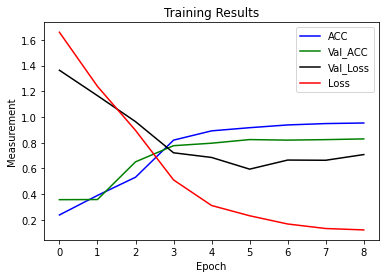

In [34]:

plt.plot(historia.history['accuracy'],'b',label = 'ACC')
plt.plot(historia.history['val_accuracy'],'g', label = 'Val_ACC')
plt.plot(historia.history['val_loss'],'k', label = 'Val_Loss')
plt.plot(historia.history['loss'],'r',label = 'Loss')
plt.title("Training Results")
plt.ylabel('Measurement')
plt.xlabel('Epoch')
plt.legend(loc ='best')
plt.show()

In [35]:
resultados = modelo.evaluate(X_testFinal, Y_test, verbose = 0)
accuracy = np.round(resultados[1],3)
print(f'Accuracy: {accuracy}')

Accuracy: 0.841


In [36]:
# Using method save() to saving successfully trained models
# Useful in case we find a great training
from datetime import date
today = str(date.today())
filepath = today +'_'+ str(accuracy)
modelo.save(filepath)
filepathh5 = filepath+'.h5'
modelo.save(filepathh5)

INFO:tensorflow:Assets written to: 2021-07-02_0.841\assets


INFO:tensorflow:Assets written to: 2021-07-02_0.841\assets


In [37]:
# !zip -r /content/prototipo_modelo1.zip /content/prototipo_modelo1

In [38]:
# In case we deleted the model (del modelo) or wanted to load it from saved data:
#!unzip prototipo_modelo1.zip -d modelo1_testfolder

# modeloCargado = load_model('/content/prototipo_modelo1')

In [39]:
Y_test

array([0, 0, 4, ..., 4, 3, 5])

In [40]:
# .hdf5 = weights ; .h5 = whole model
# modelo.load_weights('checkpoint/my_best_model.epoch09-loss0.73.hdf5')
modeloCargado = load_model('2021-06-30_0.833.h5')
resultadosCargado = modeloCargado.evaluate(X_testFinal, Y_test, verbose = 0)
print('Accuracy: {}'.format(np.round(resultadosCargado[1],3)))

OSError: SavedModel file does not exist at: 2021-06-30_0.833.h5\{saved_model.pbtxt|saved_model.pb}

## Predictions 

In [ ]:
# This function labels each result from the predictions array to a list of indexes; each index corresponds to an emotion.
# [(list(abeja[i]).index(max(abeja[i]))) for i in range(len(abeja))] this is the same thing in one line

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# This function returns the y_pred indexes (0-5) from a model.predict(x) probabilities for each emotion index.

def prediction(predicted):
  index = []
  for i in range(len(predicted)):
    max_p = max(predicted[i]) # highest value in each row of probabilities (one for each emotion).
    index.append(list(predicted[i]).index(max_p)) # we append that max probability emotion to a list and return that.
  return index

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# This function returns the y_pred emotion labels from the indexes given by prediction(model.predict(x))

def prediction_labels(prediction):
  emotions_dict = {k:v for (k,v) in zip(range(0,6), ['anger', 'fear', 'joy', 'love', 'sadness','surprise'])}
  l = []

  for i in range(len(prediction)):
        dict_key = prediction[i] # the index key for the dictionary
        l.append(emotions_dict[dict_key])

  return np.array(l)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# This function returns a dataframe with 'predicted' column which contains the predicted labels for each text.

def prediction_to_df(test_data,prediction):

    df = pd.DataFrame(columns=['text','predicted'])

    df_predicted = dataframe.copy().reset_index(drop=True) # copy of input dataframe (no changes made to original)
    df_predicted['predicted'] = "" 
        
    

In [ ]:
# This variable holds the predicted emotions for each document in input data. We will need to process it into labels.
y_pred = prediction(modelo.predict(X_testFinal))

In [ ]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

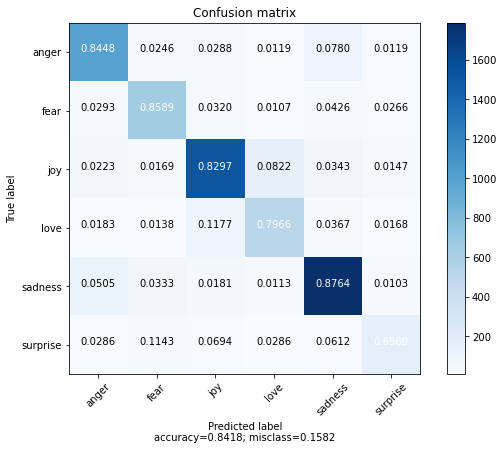

In [ ]:
# Plot confusion matrix with normalized values.
cnf_matrix = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cnf_matrix, target_names=list(dict_emotions.keys()), normalize=True)

# plt.savefig('export/confusion_matrix.png', transparent = False, format='jpg')

In [ ]:
df_predicted = prediction_to_df(X_testFinal, y_pred)

NameError: name 'dataframe' is not defined

In [ ]:
# This function compares how many predicted emotions match with actual emotions from the dataset.
# It prints successful guesses and then wrong guesses total counts.
# Then it shows a dataframe of the most common mistakes the model made (true emotion, predicted emotion) (number of mistakes)

def accuracy_comparison(dataframe1, dataframe2):

    true = 0
    false = 0
    wrong_predictions = []

    df_test = dataframe1.copy().reset_index(drop=True)
    df_predicted = dataframe2.copy().reset_index(drop=True)

    for i in range(len(df_test)):
        if df_test.emotion[i] == df_predicted.predicted[i]:
            true += 1
        else:
            false += 1
            wrong_predictions.append([df_test['emotion'][i], df_predicted['predicted'][i]])
            

    print('-' * 50)
    print(f'Successful predictions: {true} out of {len(df_test)}')
    print('-' * 50)
    print(f'Wrong predictions: {false} out of {len(df_test)}')
    print('-' * 50)
    
    lista = []
    for i in wrong_predictions:
        if i not in lista:
            lista.append(i)

    df = pd.DataFrame()
    df.insert(0, column = 'true, predicted',value='', allow_duplicates=True)
    df.insert(1, column = 'times',value='', allow_duplicates=True)

    for i in range(len(lista)):

        df2 = {'true, predicted': lista[i], 'times': wrong_predictions.count(lista[i])}
        df = df.append(df2, ignore_index = True).sort_values(by='times', ascending=False)
        
    display(df)
    cont=0
    for i in df['times']:
        cont += i
    print(f'total mistakes: {cont}')



In [ ]:
accuracy_comparison(df_test,df_predicted)

--------------------------------------------------
Successful predictions: 0 out of 0
--------------------------------------------------
Wrong predictions: 0 out of 0
--------------------------------------------------


,"true, predicted",times


total mistakes: 0


## Sentiment140 testing


In [ ]:
df_tweets = pd.read_csv('dataset/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin-1', names=['target','ids','date','flag','user','text'])

In [ ]:
# Select 2000 positive and 2000 negative tweets so that it's as unbiased as possible. Drop unneeded columns.

df_tweets = df_tweets.drop(columns=['ids','date','flag','user'])
df_tweets_final = pd.DataFrame()

df_tweets_positive = df_tweets.loc[df_tweets['target'] == 4]
df_tweets_final = df_tweets_final.append(df_tweets_positive[:2000])

df_tweets_negative = df_tweets.loc[df_tweets['target'] == 0]
df_tweets_final = df_tweets_final.append(df_tweets_negative[:2000])

df_tweets_final = df_tweets_final.reset_index(drop=True)

In [ ]:
prepare(df_tweets_final)

,target,text
0,4,"[love, guys, best]"
1,4,"[meeting, one, besties, tonight, cant, wait, g..."
2,4,"[thanks, twitter, add, sunisa, got, meet, hin,..."
3,4,"[sick, really, cheap, hurts, much, eat, real, ..."
4,4,"[effect, everyone]"
...,...,...
3995,0,"[yep, loser]"
3996,0,"[finito, bathroom, contractors, thru, house, q..."
3997,0,"[awww, sucks, going, sydney, one]"
3998,0,"[sorry, rescheduling, trip, coming, weekend, m..."


In [ ]:
df_tweets_final_encoded = encode(df_tweets_final)

In [ ]:
# Statistics for document length as an estimation for determining padding parameters.

lengths = [len(a) for a in df_tweets_final['text']]
print("Mean length: {}".format(np.mean(lengths)))
print("Lengths stdev: {}".format(np.std(lengths)))
print("Lengths Median: {}".format(np.median(lengths)))
print("Lengths Max: {}".format(np.max(lengths)))


# Choose a good value for maxlen

maxlen=np.max(lengths)


Mean length: 6.6485
Lengths stdev: 3.683808864477092
Lengths Median: 6.0
Lengths Max: 21


In [ ]:
# Pad sequencing based on maxlen variable
tweets_Final = sequence.pad_sequences(df_tweets_final_encoded, maxlen)

In [ ]:
# This variable holds the predicted emotions for each document in input data. We will need to process it into labels.
y_pred = prediction(modelo.predict(tweets_Final))

In [ ]:
labels = prediction_labels(y_pred)

In [ ]:
labels = pd.Series(labels)
labels.value_counts()

sadness     1416
joy          834
anger        737
fear         519
love         331
surprise     163
dtype: int64